# Jet Detection – Model Evaluator (MMDetection)

Bu notebook, **Cascade R-CNN** modelini (F16/F18/F22/F35) için:
- COCO metrikleriyle (**mAP / AP50 / AP75 / AR@100**) değerlendirir
- Sonuçları blok blok görselleştirir
- (Opsiyonel) **Confusion Matrix + FP/FN** analizi yapar (daha yavaş)

> Klasör düzeni
- `C:\Users\omerf\Desktop\archive`
- `C:\Users\omerf\Desktop\jet_detection_project`


In [ ]:
# Ayarlar (Notebook Evaluation)
SPLIT = "val"  # "val" veya "test"

# Opsiyonel analiz:
RUN_CONFUSION = True # En alt hücrenin çalışması için True yapmam lazım
IOU_THR = 0.5
SCORE_THR = 0.3
MAX_IMAGES = 400  # 0 => tümü (yavaş)

print("SPLIT:", SPLIT)


SPLIT: val


**İmportların olduğu kısısm.**


In [11]:
# ==== 1) Importlar ====
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mmengine.config import Config
from mmengine.runner import Runner

from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

register_all_modules()
print('Imports OK')

Imports OK


**Porje Kökü ve Dosya Yolların Ayarlandığı Yer**

In [ ]:
from pathlib import Path

# ---------------------------------------------------------
# PROJE KÖKÜNÜ BUL (script + notebook uyumlu)
# ---------------------------------------------------------
def get_project_root() -> Path:
    try:
        start = Path(__file__).resolve()
    except NameError:
        # Notebook / interactive ortam
        start = Path.cwd().resolve()

    for p in [start] + list(start.parents):
        # Senin proje yapın: <root>/codes + <root>/work_dirs
        if (p / "codes").exists() and (p / "work_dirs").exists():
            return p

    raise RuntimeError("Proje kökü bulunamadı (codes + work_dirs aranıyor)")

PROJECT_ROOT = get_project_root()

# ---------------------------------------------------------
# YOL VE CONFIG AYARLARI
# ---------------------------------------------------------
CONFIG_PATH = PROJECT_ROOT / "codes" / "configs" / "cascade_rcnn_convnext_tiny.py"
CKPT_PATH   = PROJECT_ROOT / "work_dirs" / "cascade_rcnn_r50_tiny" / "best_coco_bbox_mAP_epoch_21.pth"

# ---------------------------------------------------------
# DEBUG / KONTROL
# ---------------------------------------------------------
print("PROJECT_ROOT :", PROJECT_ROOT)
print("CONFIG_PATH  :", CONFIG_PATH)
print("CKPT_PATH    :", CKPT_PATH)
print("CONFIG exists:", CONFIG_PATH.exists())
print("CKPT exists  :", CKPT_PATH.exists())

assert CONFIG_PATH.exists(), f"Config yok: {CONFIG_PATH}"
assert CKPT_PATH.exists(), f"Ckpt yok: {CKPT_PATH}"

# ---------------------------------------------------------
# DİĞER AYARLAR
# ---------------------------------------------------------
DEVICE = "cuda:0"
print("DEVICE:", DEVICE)

OUT_DIR = PROJECT_ROOT / "testing" / "output_test"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)


PROJECT_ROOT : C:\Users\omerf\Desktop\jet_detection_project
CONFIG_PATH  : C:\Users\omerf\Desktop\jet_detection_project\codes\configs\cascade_rcnn_r50_tiny.py
CKPT_PATH    : C:\Users\omerf\Desktop\jet_detection_project\work_dirs\cascade_rcnn_r50_tiny\best_coco_bbox_mAP_epoch_21.pth
CONFIG exists: True
CKPT exists  : True
DEVICE: cuda:0
OUT_DIR: C:\Users\omerf\Desktop\jet_detection_project\testing\output_test


In [ ]:
# Config yükle + ABSOLUTE PATH PATCH + WINDOWS FIX
import os
from pathlib import Path
from mmengine.config import Config

# 1) Config dosyasını oku
cfg = Config.fromfile(str(CONFIG_PATH))


ARCHIVE_ROOT = PROJECT_ROOT.parent / "archive" / "dataset"

# Eğer proje root içindeyse diye kontrol (yedek plan)
if not ARCHIVE_ROOT.exists():
    # Archive'i proje içine atarsam diye  durusn bu ksım
    ARCHIVE_ROOT = PROJECT_ROOT / "archive" / "dataset"

print(f"Resim klasörü hedefleniyor: {ARCHIVE_ROOT}")
assert ARCHIVE_ROOT.exists(), f"Resim klasörü bulunamadı! Lütfen yolu kontrol et: {ARCHIVE_ROOT}"

# WINDOWS FIX (Donmayı önler)
if hasattr(cfg, 'train_dataloader'):
    cfg.train_dataloader.num_workers = 0
    cfg.train_dataloader.persistent_workers = False

if hasattr(cfg, 'val_dataloader'):
    cfg.val_dataloader.num_workers = 0
    cfg.val_dataloader.persistent_workers = False

if hasattr(cfg, 'test_dataloader'):
    cfg.test_dataloader.num_workers = 0
    cfg.test_dataloader.persistent_workers = False

# PATH PATCH (Absolute Path Zorlaması)
ANN_DIR = PROJECT_ROOT / "coco_annotations"
VAL_ANN  = ANN_DIR / "instances_validation.json"
TEST_ANN = ANN_DIR / "instances_test.json"

assert VAL_ANN.exists(), f"Val ann yok: {VAL_ANN}"
assert TEST_ANN.exists(), f"Test ann yok: {TEST_ANN}"

# data_root'u boşaltıyoruz ki  full path'i bozmasın
cfg.data_root = "" 

# Val Dataloader Ayarları
if hasattr(cfg, "val_dataloader") and cfg.val_dataloader is not None:
    cfg.val_dataloader.dataset.ann_file = str(VAL_ANN)
    cfg.val_dataloader.dataset.data_prefix.img = str(ARCHIVE_ROOT) + os.sep
    cfg.val_dataloader.dataset.data_root = "" # Garanti olsun

# Test Dataloader Ayarları
if hasattr(cfg, "test_dataloader") and cfg.test_dataloader is not None:
    cfg.test_dataloader.dataset.ann_file = str(TEST_ANN)
    cfg.test_dataloader.dataset.data_prefix.img = str(ARCHIVE_ROOT) + os.sep
    cfg.test_dataloader.dataset.data_root = "" # Garanti olsun

# Evaluator Ayarları
if hasattr(cfg, "val_evaluator") and cfg.val_evaluator is not None:
    if isinstance(cfg.val_evaluator, dict):
        cfg.val_evaluator.ann_file = str(VAL_ANN)
    elif isinstance(cfg.val_evaluator, list):
        for m in cfg.val_evaluator:
            if isinstance(m, dict) and "ann_file" in m:
                m["ann_file"] = str(VAL_ANN)

if hasattr(cfg, "test_evaluator") and cfg.test_evaluator is not None:
    if isinstance(cfg.test_evaluator, dict):
        cfg.test_evaluator.ann_file = str(TEST_ANN)
    elif isinstance(cfg.test_evaluator, list):
        for m in cfg.test_evaluator:
            if isinstance(m, dict) and "ann_file" in m:
                m["ann_file"] = str(TEST_ANN)

# Çalışma Ortamı Ayarları
os.chdir(PROJECT_ROOT)
cfg.load_from = str(CKPT_PATH)
cfg.device = DEVICE

# Notebook için ayrı work_dir
cfg_stem = Path(CONFIG_PATH).stem
eval_work_dir = PROJECT_ROOT / "work_dirs" / f"{cfg_stem}_nb_eval_{SPLIT}"
eval_work_dir.mkdir(parents=True, exist_ok=True)
cfg.work_dir = str(eval_work_dir)

print("-" * 40)
print("AYARLAR BAŞARIYLA GÜNCELLENDİ ✅")
print(f"Resim Yolu : {cfg.val_dataloader.dataset.data_prefix.img}")
print(f"JSON Yolu  : {cfg.val_dataloader.dataset.ann_file}")
print("-" * 40)

Resim klasörü hedefleniyor: C:\Users\omerf\Desktop\archive\dataset
----------------------------------------
AYARLAR BAŞARIYLA GÜNCELLENDİ ✅
Resim Yolu : C:\Users\omerf\Desktop\archive\dataset\
JSON Yolu  : C:\Users\omerf\Desktop\jet_detection_project\coco_annotations\instances_validation.json
----------------------------------------


In [14]:
# COCO Evaluation (en doğru ölçüm)- eğitim sırasında val yapılıyor zaten
runner = Runner.from_cfg(cfg)

if SPLIT == "val":
    metrics = runner.val()
elif SPLIT == "test":
    metrics = runner.test()
else:
    raise ValueError("SPLIT 'val' veya 'test' olmalı")

metrics = metrics or {}
print("Raw metrics keys:", list(metrics.keys())[:20])
metrics


12/24 23:31:00 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1428535420
    GPU 0: NVIDIA GeForce RTX 2060
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 2.1.2+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code

{'coco/bbox_mAP': 0.516,
 'coco/bbox_mAP_50': 0.68,
 'coco/bbox_mAP_75': 0.596,
 'coco/bbox_mAP_s': 0.104,
 'coco/bbox_mAP_m': 0.433,
 'coco/bbox_mAP_l': 0.545}

In [8]:
# Metrikleri tabloya çevir (coco/*) göster
coco_metrics = {k: v for k, v in metrics.items() if str(k).startswith("coco/")}

df = pd.DataFrame(
    [(k, float(v) if isinstance(v, (int, float, np.floating)) else v) for k, v in coco_metrics.items()],
    columns=["metric", "value"]
).sort_values("metric")

df


,metric,value
0,coco/bbox_mAP,0.516
1,coco/bbox_mAP_50,0.680
2,coco/bbox_mAP_75,0.596
5,coco/bbox_mAP_l,0.545
4,coco/bbox_mAP_m,0.433
3,coco/bbox_mAP_s,0.104


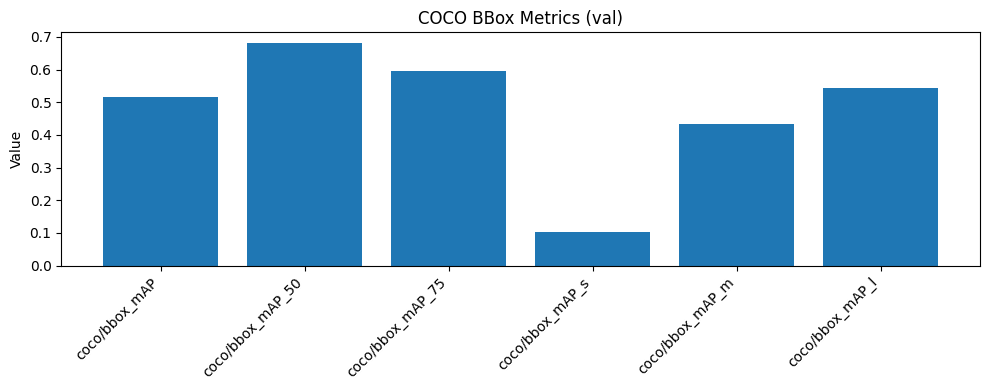

In [19]:
# Öne çıkan metrikleri bar chart ile göster 
# (Matplotlib, tek grafik, renk belirtmeden)
keys = [
    "coco/bbox_mAP",
    "coco/bbox_mAP_50",
    "coco/bbox_mAP_75",
    "coco/bbox_mAP_s",
    "coco/bbox_mAP_m",
    "coco/bbox_mAP_l",
]
vals = [coco_metrics.get(k, np.nan) for k in keys]

plt.figure(figsize=(10, 4))
plt.bar(keys, vals)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Value")
plt.title(f"COCO BBox Metrics ({SPLIT})")
plt.tight_layout()
plt.show()


## Opsiyonel: Confusion Matrix + FP/FN Analizi
Bu bölüm, **modeli tekrar inference** ettiği için daha yavaştır.
- `RUN_CONFUSION=True` yaparsan çalışır.
- `MAX_IMAGES` ile sınırlandırabilirsin.


In [ ]:
# Confusion Matrix / FP / FN / F1 SCORE  (Working version)

if not RUN_CONFUSION:
    print("RUN_CONFUSION=False => Proje başında False ayarlandığı için bu hücreyi geçiyoruz. Çünkü hesaplama yavaş ve uzun sürecektir.")
else:
    import json
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    from pycocotools.coco import COCO
    from mmdet.apis import init_detector, inference_detector

    assert SPLIT in ["val", "test"], "SPLIT 'val' veya 'test' olmalı"

    # 1) Ann file seç
    if SPLIT == "val":
        ann_file = Path(cfg.val_dataloader.dataset.ann_file)
    else:
        ann_file = Path(cfg.test_dataloader.dataset.ann_file)

    assert ann_file.exists(), f"Annotation bulunamadı: {ann_file}"

    # 2) Image root
    data_root = Path(getattr(cfg, "data_root", "") or PROJECT_ROOT)
    # data_prefix.img bazen "" olabilir
    if SPLIT == "val":
        dp = getattr(cfg.val_dataloader.dataset, "data_prefix", None)
    else:
        dp = getattr(cfg.test_dataloader.dataset, "data_prefix", None)

    prefix_img = ""
    if dp is not None:
        # mmengine ConfigDict: dp.get('img', '')
        try:
            prefix_img = dp.get("img", "")
        except Exception:
            prefix_img = getattr(dp, "img", "")

    img_root = (data_root / prefix_img).resolve()

    if not img_root.exists():
        # fallback: proje kökü
        img_root = PROJECT_ROOT.resolve()

    print("ann_file:", ann_file)
    print("img_root:", img_root)

    # 3) COCO category_id -> class index mapping 
    coco = COCO(str(ann_file))

    # classes: config'ten almaya çalış, yoksa COCO categories'den al
    classes = None
    try:
        if SPLIT == "val":
            classes = cfg.val_dataloader.dataset.metainfo["classes"]
        else:
            classes = cfg.test_dataloader.dataset.metainfo["classes"]
    except Exception:
        pass

    if classes is None:
        # COCO categories name sırasına göre
        cats = coco.loadCats(coco.getCatIds())
        classes = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]

    classes = list(classes)
    ncls = len(classes)

    # category_id -> index
    # Eğer COCO JSON'da categories id'leri 1..N değilse bile doğru çalışır.
    cats = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {c["id"]: c["name"] for c in cats}
    name_to_idx = {name: i for i, name in enumerate(classes)}
    cat_id_to_idx = {}
    for cid, name in cat_id_to_name.items():
        if name in name_to_idx:
            cat_id_to_idx[cid] = name_to_idx[name]

    if len(cat_id_to_idx) == 0:
        raise RuntimeError("Category mapping kurulamadı. COCO categories ile cfg.classes uyuşmuyor.")

    # 4) Helpers
    def coco_bbox_to_xyxy(b):
        x, y, w, h = b
        return np.array([x, y, x + w, y + h], dtype=np.float32)

    def iou_xyxy(a, b):
        x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
        x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
        iw = x2 - x1; ih = y2 - y1
        if iw <= 0 or ih <= 0:
            return 0.0
        inter = iw * ih
        area_a = (a[2]-a[0])*(a[3]-a[1])
        area_b = (b[2]-b[0])*(b[3]-b[1])
        union = area_a + area_b - inter
        return float(inter/union) if union > 0 else 0.0

    # 5) Model load (en stabil)
    device = DEVICE if "cuda" in DEVICE else "cpu"
    assert CKPT_PATH.exists(), f"Ckpt yok: {CKPT_PATH}"
    assert CONFIG_PATH.exists(), f"Config yok: {CONFIG_PATH}"

    model = init_detector(str(CONFIG_PATH), str(CKPT_PATH), device=device)
    print("Model loaded on:", device)

    # 6) Loop
    img_ids = coco.getImgIds()
    if MAX_IMAGES and MAX_IMAGES > 0:
        img_ids = img_ids[:MAX_IMAGES]

    conf = np.zeros((ncls, ncls), dtype=np.int64)
    fp = np.zeros((ncls,), dtype=np.int64)
    fn = np.zeros((ncls,), dtype=np.int64)

    missing_imgs = 0

    for img_id in img_ids:
        img_info = coco.loadImgs([img_id])[0]
        img_path = (img_root / img_info["file_name"]).resolve()

        if not img_path.exists():
            missing_imgs += 1
            continue

        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ann_ids)

        # GT
        gt_boxes = np.array([coco_bbox_to_xyxy(a["bbox"]) for a in anns], dtype=np.float32) if anns else np.zeros((0,4), dtype=np.float32)
        gt_labels = []
        for a in anns:
            cid = int(a["category_id"])
            if cid in cat_id_to_idx:
                gt_labels.append(cat_id_to_idx[cid])
        gt_labels = np.array(gt_labels, dtype=np.int64) if gt_labels else np.zeros((0,), dtype=np.int64)

        # Pred
        result = inference_detector(model, str(img_path))

        if hasattr(result, "pred_instances"):
            inst = result.pred_instances
            b = inst.bboxes.detach().cpu().numpy()
            l = inst.labels.detach().cpu().numpy().astype(np.int64)
            s = inst.scores.detach().cpu().numpy()
            keep = s >= SCORE_THR
            pred_boxes = b[keep]
            pred_labels = l[keep]
        else:
            # Eski format fallback
            pred_boxes = []
            pred_labels = []
            for cls_id, arr in enumerate(result):
                if arr is None or len(arr) == 0:
                    continue
                for row in arr:
                    x1,y1,x2,y2,sc = row
                    if sc >= SCORE_THR:
                        pred_boxes.append([x1,y1,x2,y2])
                        pred_labels.append(cls_id)
            pred_boxes = np.array(pred_boxes, dtype=np.float32) if pred_boxes else np.zeros((0,4), dtype=np.float32)
            pred_labels = np.array(pred_labels, dtype=np.int64) if pred_labels else np.zeros((0,), dtype=np.int64)

        used_gt = set()

        # Match predictions to GT by IoU (class-agnostic matching)
        for i in range(len(pred_boxes)):
            pb = pred_boxes[i]
            pl = int(pred_labels[i])

            best_iou = 0.0
            best_j = -1
            for j in range(len(gt_boxes)):
                if j in used_gt:
                    continue
                iou = iou_xyxy(pb, gt_boxes[j])
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_j >= 0 and best_iou >= IOU_THR:
                tl = int(gt_labels[best_j])
                conf[tl, pl] += 1
                used_gt.add(best_j)
            else:
                if 0 <= pl < ncls:
                    fp[pl] += 1

        # Unmatched GT => FN
        for j in range(len(gt_boxes)):
            if j not in used_gt:
                tl = int(gt_labels[j])
                fn[tl] += 1

    print("Confusion matrix computed.")
    if missing_imgs > 0:
        print(f"⚠️ Missing images skipped: {missing_imgs} (img_root or file_name mismatch)")

    # 7) Plot confusion
    plt.figure(figsize=(10, 8))
    plt.imshow(conf, interpolation="nearest")
    plt.title(f"Confusion Matrix ({SPLIT}) IoU>={IOU_THR} score>={SCORE_THR}")
    plt.colorbar()
    tick = np.arange(ncls)
    plt.xticks(tick, classes, rotation=45, ha="right")
    plt.yticks(tick, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i in range(ncls):
        for j in range(ncls):
            plt.text(j, i, str(conf[i, j]), ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

    # 8) FP/FN + F1 (basit)
    tp = np.diag(conf).astype(np.int64)
    precision = tp / np.maximum(tp + fp, 1)
    recall = tp / np.maximum(tp + fn, 1)
    f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-12)

    df_err = pd.DataFrame({
        "class": classes,
        "TP": tp,
        "FP": fp.astype(int),
        "FN": fn.astype(int),
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    })

    df_err


NameError: name 'cfg' is not defined